# Importing Libraries 

In [65]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import eda_helper_function

In [66]:
# Reading the training data
train = pd.read_csv(r'C:\Users\Admin\Projects\Flight-sagemaker-project\data\train.csv')
train.head()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-03-21,Banglore,New Delhi,08:55:00,19:10:00,615,1.0,In-flight meal not included,7832
1,Jet Airways,2019-03-27,Delhi,Cochin,17:30:00,04:25:00,655,1.0,In-flight meal not included,6540
2,Goair,2019-03-09,Banglore,New Delhi,11:40:00,14:35:00,175,0.0,No Info,7305
3,Air India,2019-06-12,Kolkata,Banglore,09:25:00,18:30:00,545,1.0,No Info,8366
4,Jet Airways,2019-03-12,Banglore,New Delhi,22:55:00,07:40:00,525,1.0,In-flight meal not included,11087


In [67]:
train.shape

(6695, 10)

In [68]:
train.dtypes

airline             object
date_of_journey     object
source              object
destination         object
dep_time            object
arrival_time        object
duration             int64
total_stops        float64
additional_info     object
price                int64
dtype: object

In [69]:
# changing datatype of dates columns
train = train.assign(**{
    col : pd.to_datetime(train.loc[:,col],dayfirst=True,format='mixed')
    for col in ['date_of_journey','dep_time','arrival_time']
})

In [70]:
train.dtypes

airline                    object
date_of_journey    datetime64[ns]
source                     object
destination                object
dep_time           datetime64[ns]
arrival_time       datetime64[ns]
duration                    int64
total_stops               float64
additional_info            object
price                       int64
dtype: object

## High level summary

In [71]:
train.describe(include='number')

,duration,total_stops,price
count,6695.000000,6694.000000,6695.000000
mean,633.489171,0.801464,9030.965646
std,503.006311,0.659737,4639.522857
min,75.000000,0.000000,1759.000000
25%,170.000000,0.000000,5224.000000
50%,510.000000,1.000000,8283.000000
75%,922.500000,1.000000,12373.000000
max,2860.000000,3.000000,62427.000000


In [72]:
train.describe(include='O')

,airline,source,destination,additional_info
count,6695,6695,6695,6695
unique,9,5,6,7
top,Jet Airways,Delhi,Cochin,No Info
freq,2391,2730,2730,5249


In [73]:
(
    train
    .assign(total_stops = train['total_stops'].astype(object))
    .describe(include='O')
)

,airline,source,destination,total_stops,additional_info
count,6695,6695,6695,6694.0,6695
unique,9,5,6,4.0,7
top,Jet Airways,Delhi,Cochin,1.0,No Info
freq,2391,2730,2730,3580.0,5249


## High level analysis for missing values

In [74]:
eda_helper_function.missing_info(train)

,count,percentage
variable,,
total_stops,1,0.014937


In [75]:
np.where(train['total_stops'].isnull())

(array([2534], dtype=int64),)

In [76]:
train.iloc[142,:]

airline                       Spicejet
date_of_journey    2019-06-06 00:00:00
source                           Delhi
destination                     Cochin
dep_time           2024-05-23 15:45:00
arrival_time       2024-05-23 22:05:00
duration                           380
total_stops                        1.0
additional_info                No Info
price                             5583
Name: 142, dtype: object

It is observed that there is some ambiguity is present in missing value data as departure time and arrival time does not matched.

In [77]:
train = train.dropna()

In [78]:
eda_helper_function.missing_info(train)

,count,percentage
variable,,


## High level analysis for outliers

We use isolation forest

In [79]:
from sklearn.ensemble import IsolationForest

In [80]:
forest = IsolationForest(n_estimators=10,random_state=42)

In [81]:
( 
    train
    .assign(outlier = forest.fit_predict(train
                                         .drop(columns='price')
                                         .select_dtypes(include='number')))
    .query('outlier == -1')
    #.duration
    #.describe()
)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price,outlier
5,Jet Airways,2019-04-21,Banglore,Delhi,2024-05-23 18:55:00,2024-05-23 22:00:00,185,0.0,In-flight meal not included,4544,-1
7,Spicejet,2019-06-15,Mumbai,Hyderabad,2024-05-23 05:45:00,2024-05-23 07:15:00,90,0.0,No check-in baggage included,2647,-1
9,Jet Airways,2019-05-09,Delhi,Cochin,2024-05-23 23:05:00,2024-05-23 04:25:00,1760,2.0,No Info,15129,-1
10,Jet Airways,2019-06-12,Kolkata,Banglore,2024-05-23 14:05:00,2024-05-23 10:05:00,1200,1.0,No Info,13044,-1
12,Jet Airways,2019-06-24,Delhi,Cochin,2024-05-23 21:25:00,2024-05-23 19:00:00,1295,2.0,No Info,13292,-1
...,...,...,...,...,...,...,...,...,...,...,...
6687,Air India,2019-06-06,Kolkata,Banglore,2024-05-23 05:50:00,2024-05-23 08:55:00,1625,2.0,No Info,12723,-1
6688,Jet Airways,2019-06-15,Delhi,Cochin,2024-05-23 21:25:00,2024-05-23 12:35:00,910,2.0,In-flight meal not included,9905,-1
6689,Indigo,2019-03-03,Mumbai,Hyderabad,2024-05-23 09:10:00,2024-05-23 10:40:00,90,0.0,No Info,5755,-1
6690,Jet Airways,2019-03-21,Delhi,Cochin,2024-05-23 10:45:00,2024-05-23 18:50:00,1925,2.0,No Info,11093,-1


## Pair plots

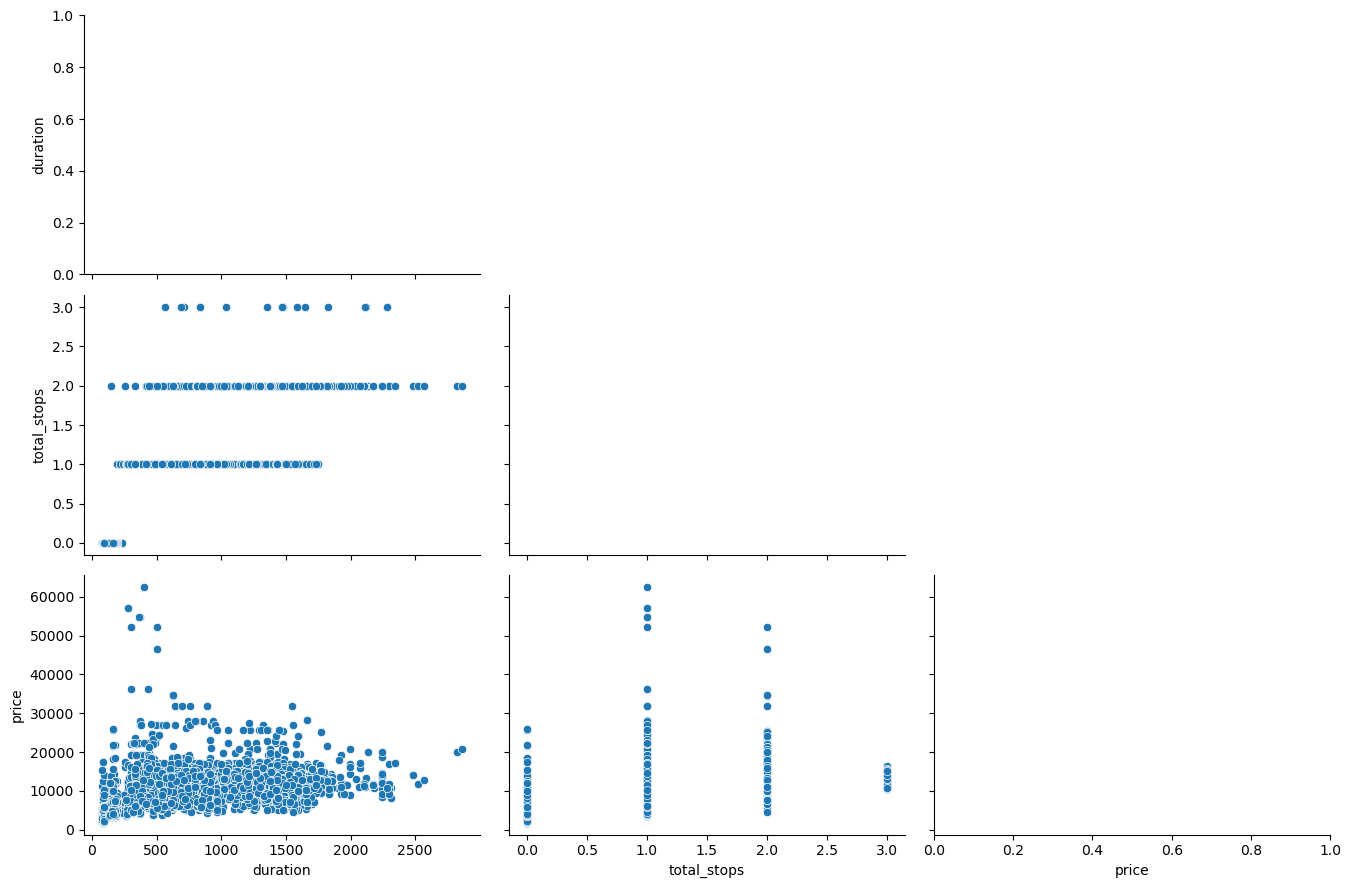

In [82]:
eda_helper_function.pair_plots(train)

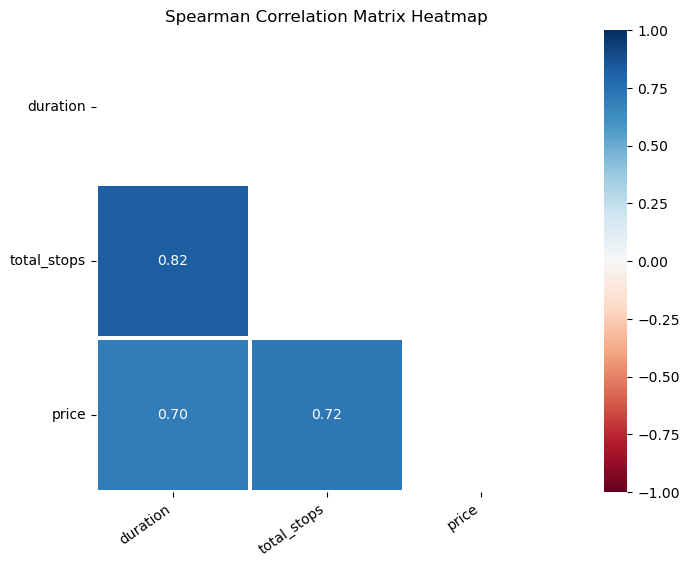

In [83]:
eda_helper_function.correlation_heatmap(train)

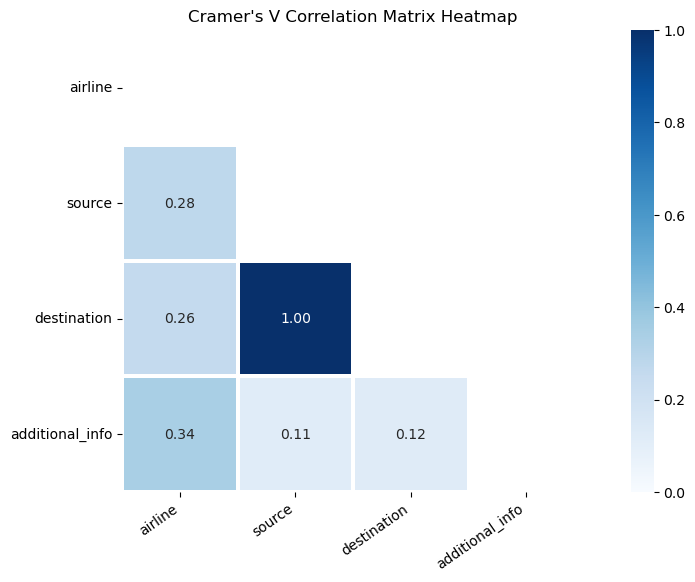

In [84]:
#This method use chi square test
eda_helper_function.cramersV_heatmap(train)

## Detailed analysis

In [85]:
train.columns

Index(['airline', 'date_of_journey', 'source', 'destination', 'dep_time',
       'arrival_time', 'duration', 'total_stops', 'additional_info', 'price'],
      dtype='object')

### 8.1 Airline

In [86]:
eda_helper_function.cat_summary(train,'airline')

0       Jet Airways
1       Jet Airways
2             Goair
3         Air India
4       Jet Airways
           ...     
6690    Jet Airways
6691      Air India
6692    Jet Airways
6693       Air Asia
6694      Air India
Name: airline, Length: 6694, dtype: object

Data Type      : object
Cardinality    : 9 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 6,694 / 6,694 rows


,
count,6694
unique,9
top,Jet Airways
freq,2391


,count,percentage
category,,
Jet Airways,2391,0.357186
Indigo,1296,0.193606
Air India,1075,0.160592
Multiple Carriers,736,0.109949
Spicejet,537,0.080221
Vistara,322,0.048103
Air Asia,211,0.031521
Goair,125,0.018673
Trujet,1,0.000149


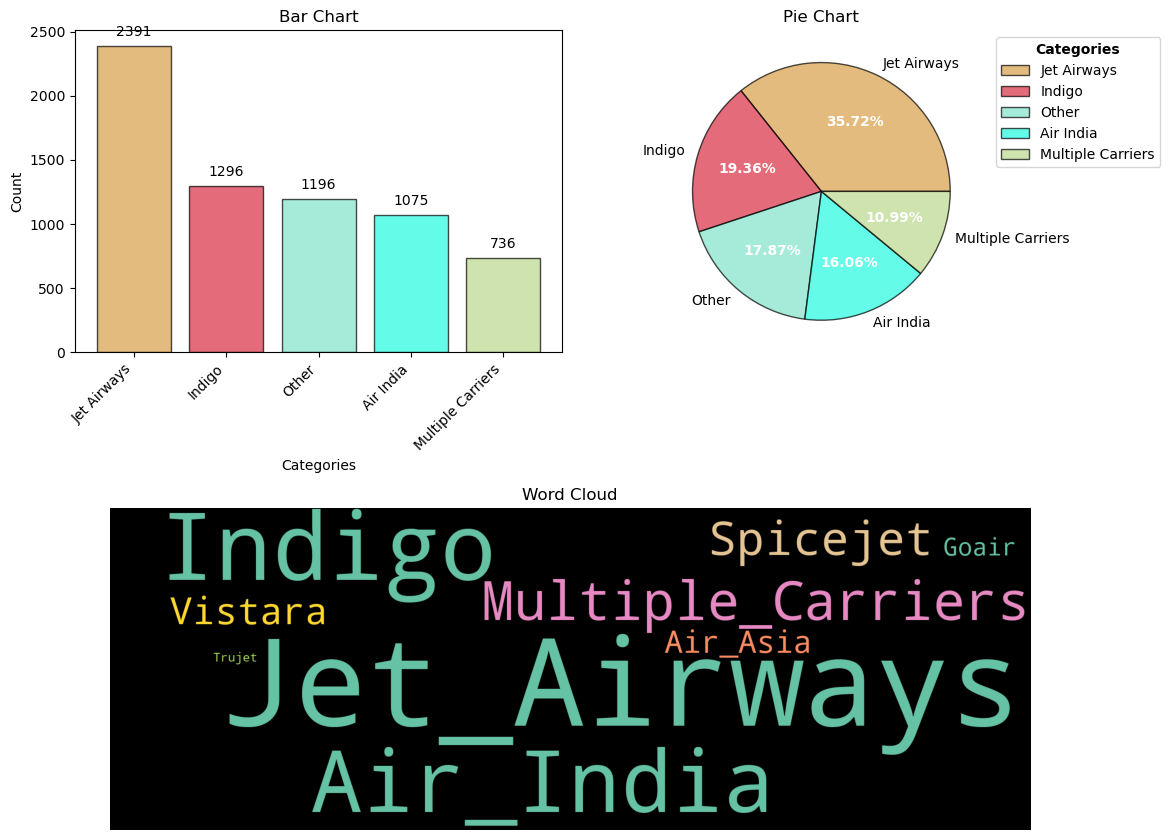

In [88]:
eda_helper_function.cat_univar_plots(train,'airline',k=4)

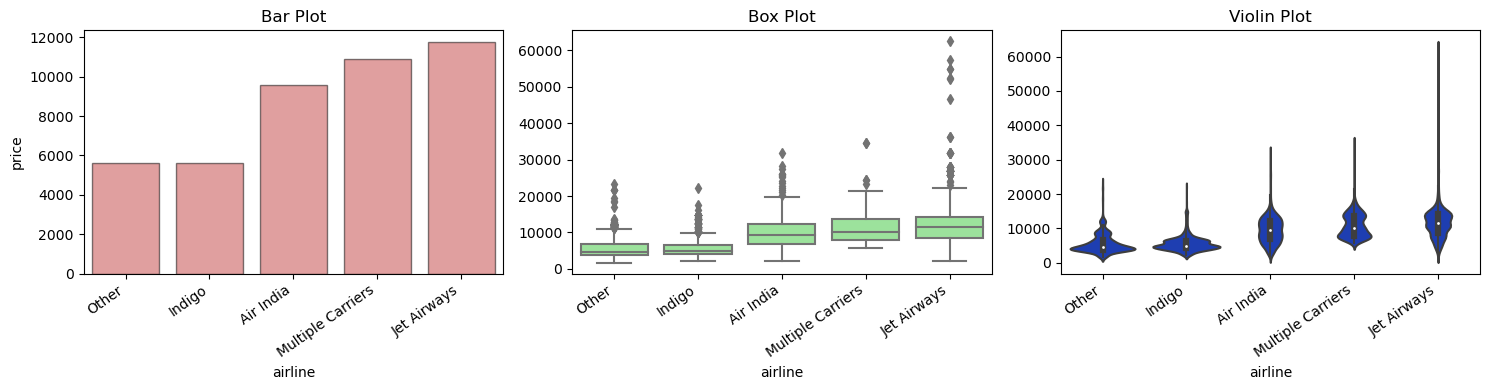

In [91]:
eda_helper_function.num_cat_bivar_plots(data=train,num_var='price',
                                        cat_var='airline',k=4)

In [92]:
eda_helper_function.num_cat_hyp_testing(train,'price','airline')

- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population mean
- Alternate Hypothesis : The groups don't have similar population mean
- Test Statistic       : 473.2504388077414
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population median
- Alternate Hypothesis : The groups don't have similar population median
- Test Statistic       : 3130.947388921903
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


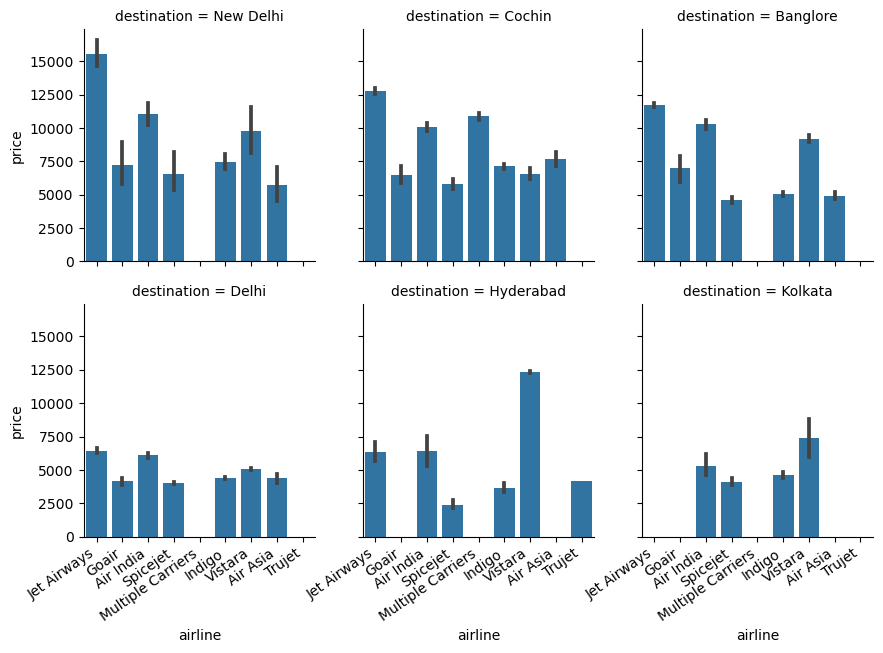

In [98]:
airline_grid = sns.FacetGrid(data=train,col='destination',col_wrap=3,sharey=True)
airline_grid.map(sns.barplot,'airline','price',order = train.airline.unique())
for ax in airline_grid.axes[3:]:
    eda_helper_function.rotate_xlabels(ax)

In [96]:
airline_grid.axes

array([<Axes: title={'center': 'destination = New Delhi'}, ylabel='price'>,
       <Axes: title={'center': 'destination = Cochin'}>,
       <Axes: title={'center': 'destination = Banglore'}>,
       <Axes: title={'center': 'destination = Delhi'}, xlabel='airline', ylabel='price'>,
       <Axes: title={'center': 'destination = Hyderabad'}, xlabel='airline'>,
       <Axes: title={'center': 'destination = Kolkata'}, xlabel='airline'>],
      dtype=object)

In [97]:
for ax in airline_grid.axes[3:]:
    eda_helper_function.rotate_xlabels(ax)

### 8.2 date of journey

In [99]:
train.date_of_journey

0      2019-03-21
1      2019-03-27
2      2019-03-09
3      2019-06-12
4      2019-03-12
          ...    
6690   2019-03-21
6691   2019-05-01
6692   2019-06-01
6693   2019-06-24
6694   2019-03-01
Name: date_of_journey, Length: 6694, dtype: datetime64[ns]

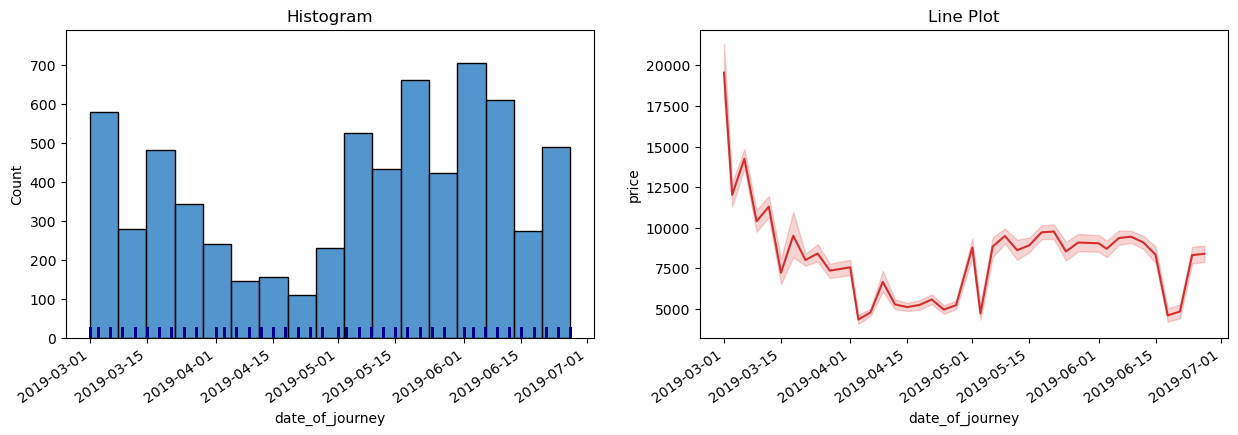

In [101]:
eda_helper_function.dt_univar_plots(train,
                                    var = 'date_of_journey',
                                    target = 'price')

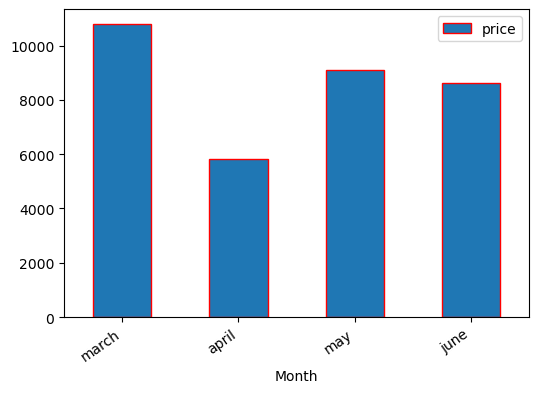

In [110]:
(train
 .groupby((pd.Grouper(key='date_of_journey',freq='M')))
 .price.mean()
 .to_frame()
 .set_axis(['march','april','may','june'],axis=0)
 .rename_axis(index='Month')
 .plot(kind='bar',figsize=(6,4),edgecolor='red')
 )

ax = plt.gca()
eda_helper_function.rotate_xlabels(ax)

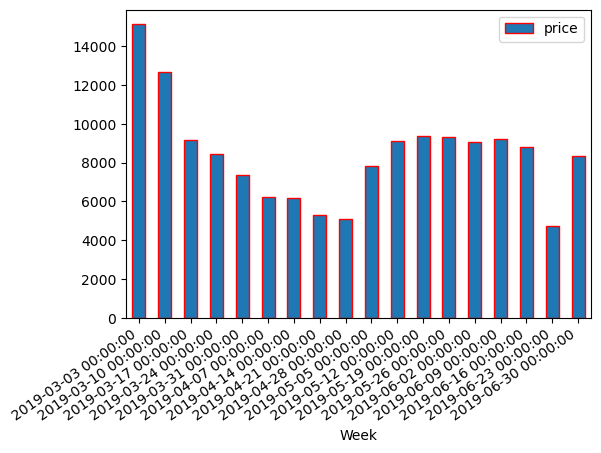

In [113]:
(train
 .groupby((pd.Grouper(key='date_of_journey',freq='W')))
 .price.mean()
 .to_frame()
 #.set_axis(['march','april','may','june'],axis=0)
 .rename_axis(index='Week')
 .plot(kind='bar',figsize=(6,4),edgecolor='red')
 )

ax = plt.gca()
eda_helper_function.rotate_xlabels(ax)

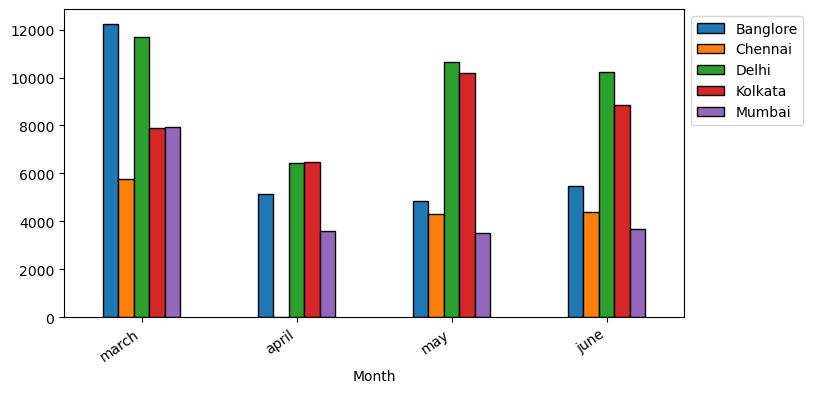

In [120]:
( 
    train
    .groupby([pd.Grouper(key='date_of_journey',freq='M'),'source'])
    .price.mean()
    .unstack(fill_value=0)
    #.to_frame()
    .set_axis(['march','april','may','june'],axis=0)
    .rename_axis(index='Month')
    .plot(kind='bar',figsize=(8,4),edgecolor='black')
 )

ax = plt.gca()
eda_helper_function.rotate_xlabels(ax)
ax.legend(
    loc='upper left',
    bbox_to_anchor = (1,1)

)


### 8.3 Departure time

In [121]:
train.dep_time

0      2024-05-23 08:55:00
1      2024-05-23 17:30:00
2      2024-05-23 11:40:00
3      2024-05-23 09:25:00
4      2024-05-23 22:55:00
               ...        
6690   2024-05-23 10:45:00
6691   2024-05-23 09:25:00
6692   2024-05-23 14:00:00
6693   2024-05-23 07:55:00
6694   2024-05-23 11:50:00
Name: dep_time, Length: 6694, dtype: datetime64[ns]

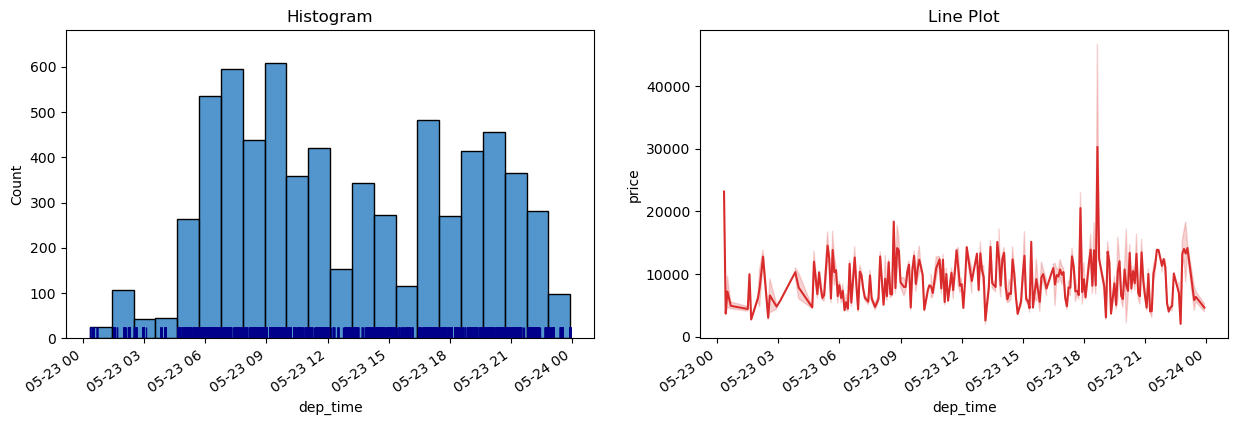

In [122]:
eda_helper_function.dt_univar_plots(train,'dep_time','price')

In [128]:
(
    train
    .dep_time
    .dt.hour
    .pipe(lambda ser:np.select([ser.between(4,12,inclusive='left'),
                                ser.between(12,16,inclusive='left'),
                                ser.between(16,20,inclusive='left')],
                               ['morning','afternoon','evening'],
                               default = 'night'))
    
)

array(['morning', 'evening', 'morning', ..., 'afternoon', 'morning',
       'morning'], dtype='<U9')

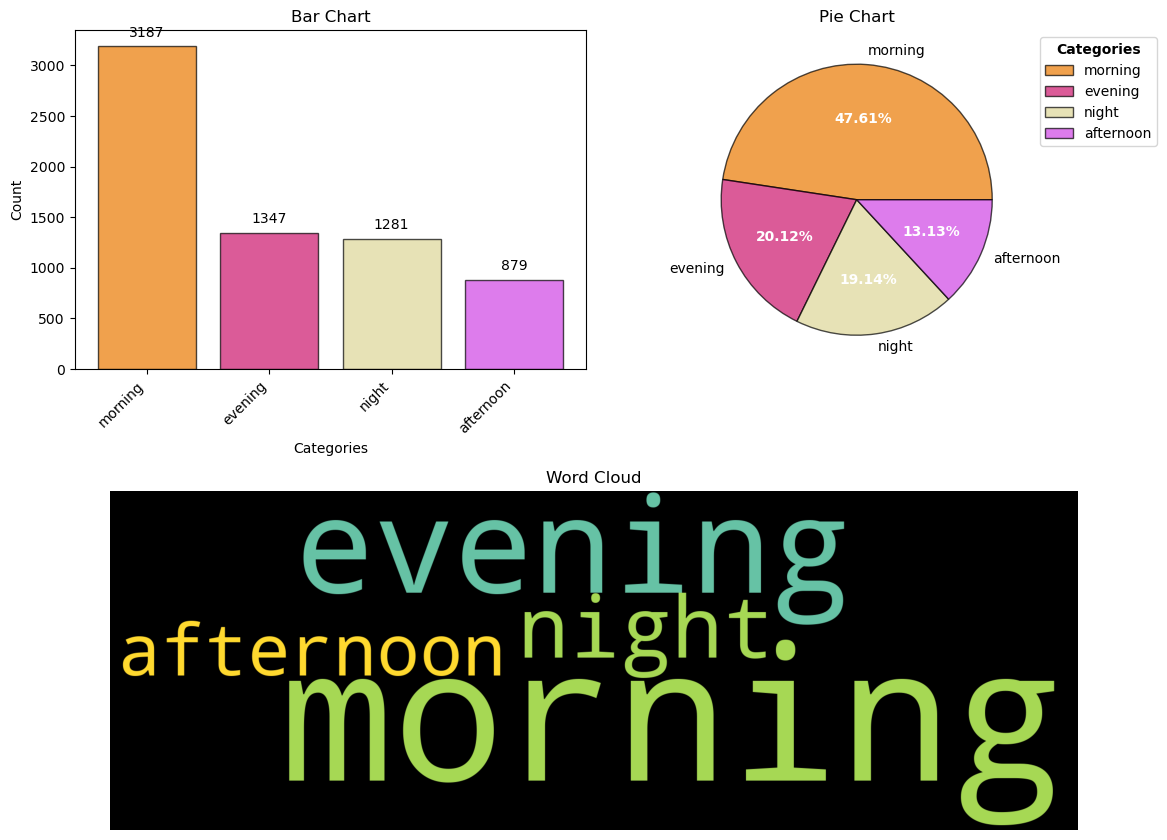

In [131]:
(
    train
    .assign(dep_time = lambda df_:(
        np.select([df_.dep_time.dt.hour.between(4,12,inclusive='left'),
                   df_.dep_time.dt.hour.between(12,16,inclusive='left'),
                   df_.dep_time.dt.hour.between(16,20,inclusive='left')],
                   ['morning','afternoon','evening'],
                   default = 'night'))
    )
    .pipe(eda_helper_function.cat_univar_plots,'dep_time')
)

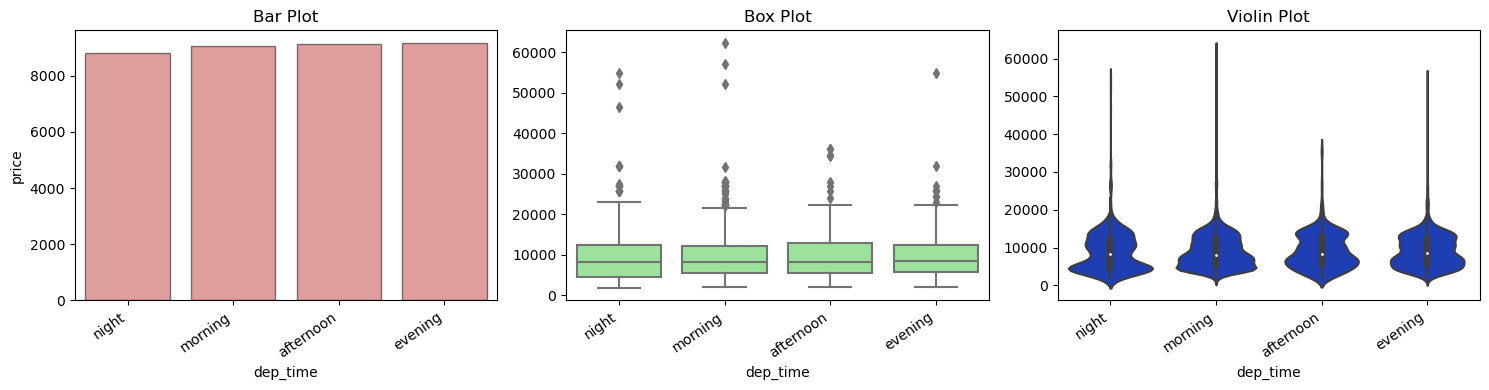

In [132]:
(
    train
    .assign(dep_time = lambda df_:(
        np.select([df_.dep_time.dt.hour.between(4,12,inclusive='left'),
                   df_.dep_time.dt.hour.between(12,16,inclusive='left'),
                   df_.dep_time.dt.hour.between(16,20,inclusive='left')],
                   ['morning','afternoon','evening'],
                   default = 'night'))
    )
    .pipe(eda_helper_function.num_cat_bivar_plots,'price','dep_time')
)

### 8.4 Duration

In [133]:
train.duration

0        615
1        655
2        175
3        545
4        525
        ... 
6690    1925
6691     545
6692     300
6693     330
6694    1265
Name: duration, Length: 6694, dtype: int64

In [134]:
eda_helper_function.num_summary(train,'duration')

0        615
1        655
2        175
3        545
4        525
        ... 
6690    1925
6691     545
6692     300
6693     330
6694    1265
Name: duration, Length: 6694, dtype: int64

Data Type      : int64
Missing Data   : 0 rows (0.00 %)
Available Data : 6,694 / 6,694 rows


,value
percentile,
0,75.00
5,90.00
10,145.00
25,170.00
50,510.00
75,920.00
90,1440.00
95,1601.75
99,1855.00


,value
mean,633.371676
trimmed mean (5%),599.575174
trimmed mean (10%),570.895258
median,510.000000


,value
var,252960.712875
std,502.951999
IQR,750.000000
mad,340.000000
coef_variance,0.794087


,value
skewness,0.894131
kurtosis,-0.052204


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
p-value              : 0.0
Test Statistic       : 0.8865419626235962
- Since p-value is less than alpha (0.05), we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
Critical Value       : 0.787
Test Statistic       : 248.45769626661695
- Since the Test-statistic is greater than Critical Value, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


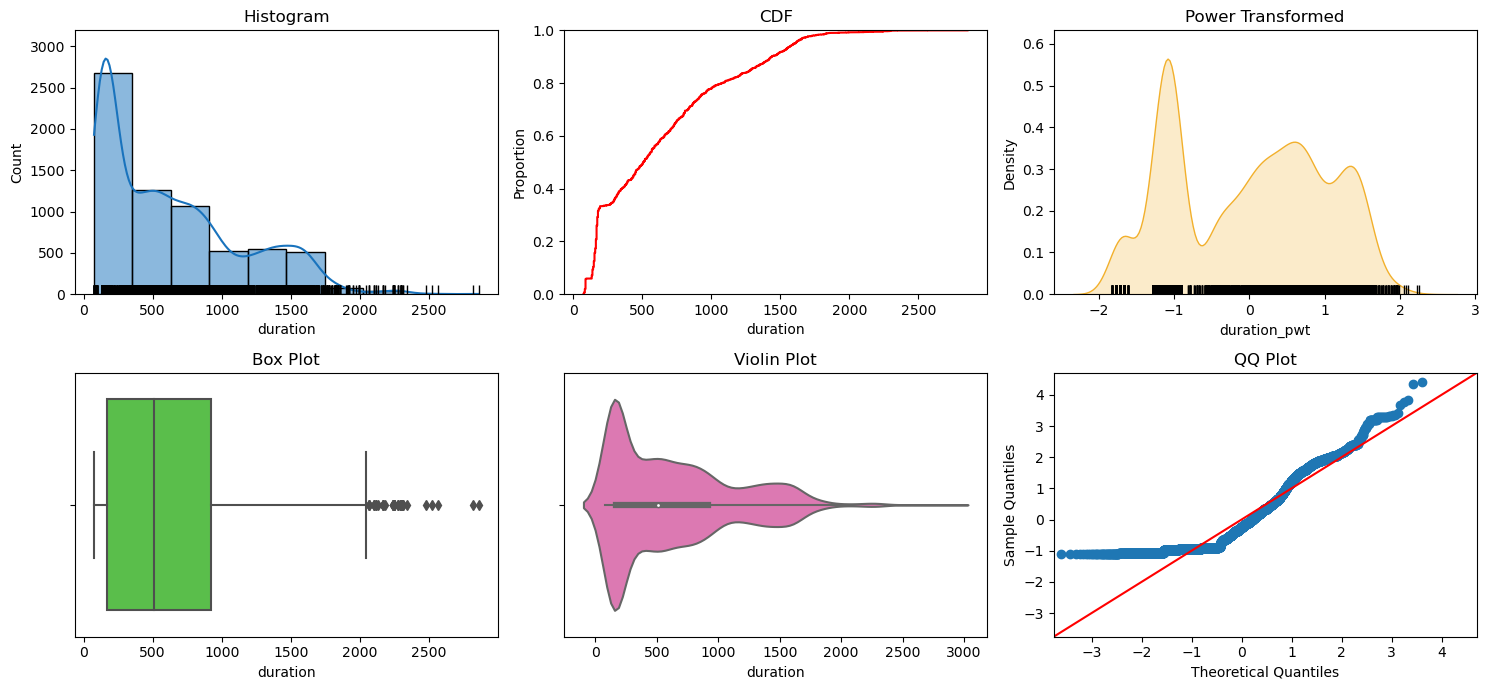

In [135]:
eda_helper_function.num_univar_plots(train,'duration')

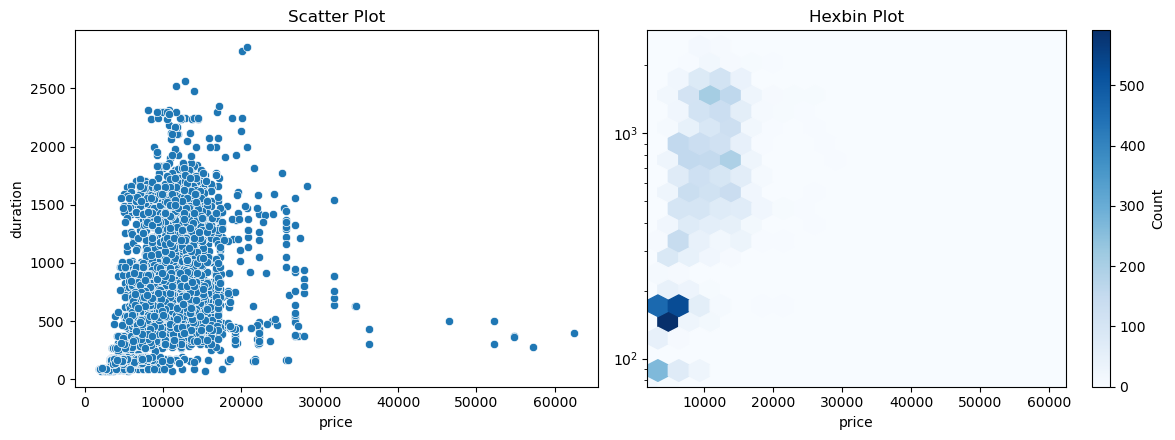

In [139]:
eda_helper_function.num_bivar_plots(train,'price','duration',
                                    hexbin_kwargs = dict(yscale ='log',
                                    gridsize=20,
                                    cmap='Blues'))

In [140]:
eda_helper_function.num_num_hyp_testing(train,'duration','price')

- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.5091878071906605
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables duration and price are correlated


- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.6980000420004596
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables duration and price are correlated


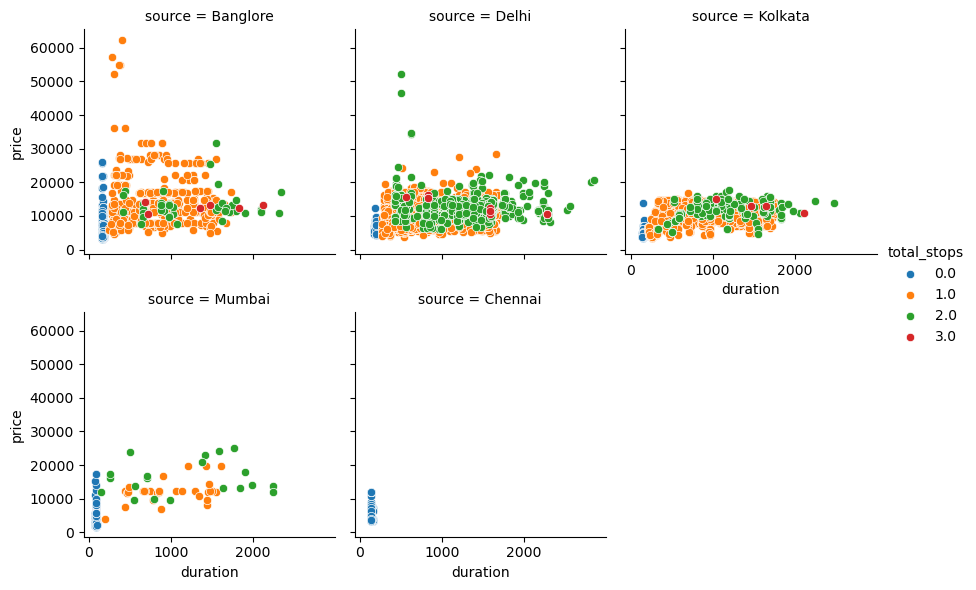

In [145]:
duration_grid = sns.FacetGrid(
    data = train,
    col  = 'source',
    hue  = 'total_stops',
    sharey = True,
    col_wrap=3
)
duration_grid.map(sns.scatterplot,'duration','price')
duration_grid.add_legend()

## Automated profile report

In [147]:
! pip install ydata-profiling

                                              0.0/359.5 kB ? eta -:--:--
     --                                       20.5/359.5 kB ? eta -:--:--
     --                                       20.5/359.5 kB ? eta -:--:--
     -------                               71.7/359.5 kB 558.5 kB/s eta 0:00:01
     -------                               71.7/359.5 kB 558.5 kB/s eta 0:00:01
     --------------------                 204.8/359.5 kB 953.7 kB/s eta 0:00:01
     --------------------                 204.8/359.5 kB 953.7 kB/s eta 0:00:01
     ----------------------------------     327.7/359.5 kB 1.0 MB/s eta 0:00:01
     ----------------------------------     327.7/359.5 kB 1.0 MB/s eta 0:00:01
     ------------------------------------ 359.5/359.5 kB 827.6 kB/s eta 0:00:00
                                              0.0/409.3 kB ? eta -:--:--
     -------------------------                256.0/409.3 kB ? eta -:--:--
     -------------------------                256.0/409.3 kB ? eta -:--

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
qudida 0.0.4 requires opencv-python-headless>=4.0.1, which is not installed.
fastapi 0.78.0 requires pydantic!=1.7,!=1.7.1,!=1.7.2,!=1.7.3,!=1.8,!=1.8.1,<2.0.0,>=1.6.2, but you have pydantic 2.7.1 which is incompatible.


In [148]:
from ydata_profiling import ProfileReport

In [149]:
report = ProfileReport(train)

In [150]:
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]